In [1]:
#import all libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,balanced_accuracy_score,precision_recall_curve, roc_curve
from all_class import *
from sklearn.ensemble import VotingClassifier

In [2]:
Features=35
Index_2016,All_columns,Maturity_2016,Final_Data_2016,Final_Data_Selected_2016=datacreate_2016(file='C:/Users/tusha/Downloads/Peanut_Maturity.csv'\
                                                                  ,path1='C:/All/Peanut_Maturity_Classification',W_select=205)
Index_2017,Maturity_2017,Final_Data_2017,Final_Data_Selected_2017=datacreate_2017(file='C:/Users/tusha/Downloads/Peanut_Maturity_.csv'\
                                                                  ,path2='C:/All/Peanut_Maturity_Classification_2017',W_select=205)

In [3]:
X_train,X_test,y_train,y_test=train_test_dataset_create(Features=Features,X_train=Final_Data_Selected_2016,\
                                                        X_test=Final_Data_Selected_2017,y_train=Maturity_2016,\
                                                        y_test=Maturity_2017)

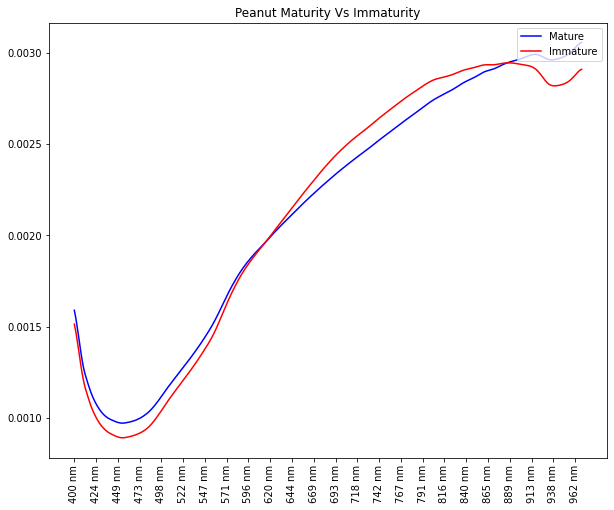

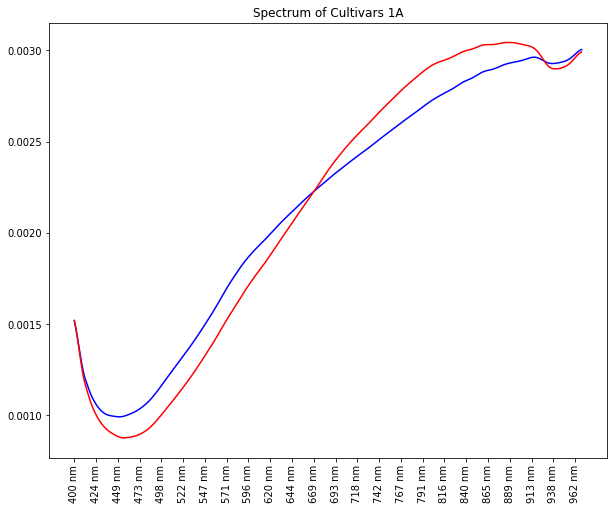

In [9]:
year='2017'
plot_cultivars(Feature=Final_Data_2017,Wavelength=All_columns,Label=Maturity_2017,year=year,Cultivar='All',Index=Index_2017)
plot_cultivars(Feature=Final_Data_2017,Wavelength=All_columns,Label=Maturity_2017,year=year,Cultivar='1A',Index=Index_2017)

In [6]:
#Set the model LR model classification
"""
Make a pipline of preprocessing, a grid of parameters for the classifier, fit the model, evaluate the model (Writing into a text file) 
"""
#Make a pipeline containing standard scaling, PCA, estimator
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2*Features-5), LogisticRegression());
#making a parameter grid by varing C, random_state and tolerance of logistic regression
parameter_grid_lr=[{'logisticregression__C':[10**i for i in [-6,-4,-3,-2,-1, 0, 1, 2,3]], 
                    'logisticregression__random_state': list(range(1,50)), 
                    'logisticregression__tol': [10**i for i in [-4,-6,-8,-10]], 
                    'logisticregression__multi_class':['auto'], 
                    'logisticregression__max_iter': [5000], 
                    'logisticregression__class_weight': ['balanced'], 
                    'logisticregression__solver': ['lbfgs']}]
#Creating grid search object and fit in the data
#Cross_validation step can be done in grid search, that is why I avoided manual cross validation
gsr = GridSearchCV(estimator=pipe_lr,param_grid=parameter_grid_lr, scoring='accuracy',cv=10,refit=True,n_jobs=-1)
gsr = gsr.fit(X_train, y_train)

In [7]:
y_pred_train=gsr.predict(X_train)
y_pred_test=gsr.predict(X_test)

Train_Confusion_matrix_lr, Test_Confusion_matrix_lr = confusion_matrix(y_train,y_pred_train), \
confusion_matrix(y_test,y_pred_test)
Train_specificity_lr, Test_specificity_lr = specificity(Train_Confusion_matrix_lr), specificity(Test_Confusion_matrix_lr)
Train_accuracy_score_lr,Test_accuracy_score_lr = gsr.score(X_train, y_train),gsr.score(X_test, y_test);
Train_precision_score_lr, Test_precision_score_lr=precision_score(y_train,y_pred_train), precision_score(y_test,y_pred_test)
Train_recall_score_lr, Test_recall_score_lr=recall_score(y_train,y_pred_train), recall_score(y_test,y_pred_test)
Train_f1_score_lr, Test_f1_score_lr=f1_score(y_train,y_pred_train), f1_score(y_test,y_pred_test)
Train_balanced_accuracy_score_lr,Test_balanced_accuracy_score_lr=balanced_accuracy_score(y_train,y_pred_train),\
balanced_accuracy_score(y_test,y_pred_test)

file = open(f"Result_LR_{Features}.txt", "w")
file.write(f"\nBest parameter for Logistic regression Model is:\n {str(gsr.best_params_)} for {Features} Features")
file.write(f"\n Metrics: Train_result ,Test_result ")
file.write(f"\n Confusion_matrix: Train_result: {Train_Confusion_matrix_lr},Test_result: {Test_Confusion_matrix_lr}")
file.write(f"\n Accuracy_score: Train_result: {Train_accuracy_score_lr},Test_result: {Test_accuracy_score_lr}")
file.write(f"\n Precision_score: Train_result: {Train_precision_score_lr},Test_result: {Test_precision_score_lr}")
file.write(f"\n Recall_score: Train_result: {Train_recall_score_lr},Test_result: {Test_recall_score_lr}")
file.write(f"\n f1_score: Train_result: {Train_f1_score_lr},Test_result: {Test_f1_score_lr}")
file.write(f"\n Balanced_accuracy: Train_result: {Train_balanced_accuracy_score_lr},Test_result: {Test_balanced_accuracy_score_lr}")
file.write(f"\n Specificity: Train_result: {Train_specificity_lr},Test_result: {Test_specificity_lr}")
file.close()

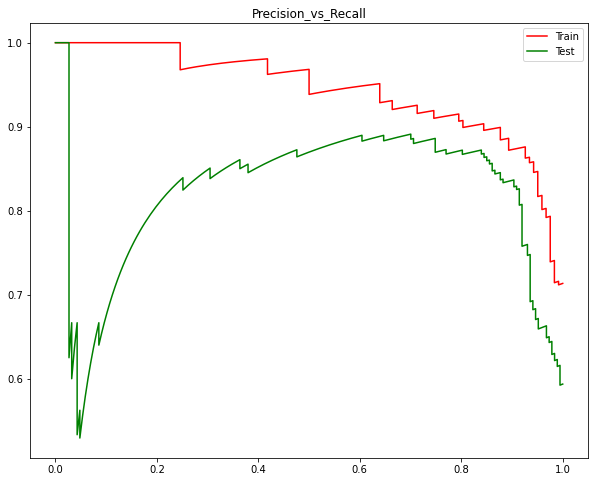

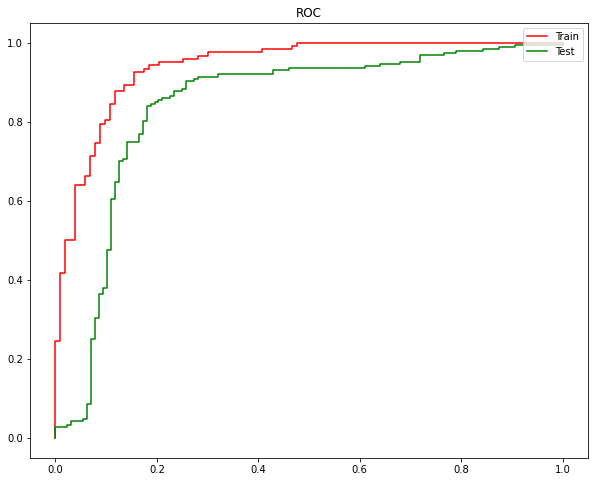

In [10]:
#Plotting ROC_AUC curve and Precision Recall_curve
y_pred_train=gsr.predict_proba(X_train)
y_pred_test=gsr.predict_proba(X_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_train[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])
plt.figure(figsize=(10,8))
plt.plot(recall_train,precision_train,'-r')
plt.plot(recall_test,precision_test,'-g')
plt.title('Precision_vs_Recall')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'Precision_vs_Recall_Features_{Features}_year_{year}.jpg',dpi=600)
plt.figure(figsize=(10,8))
plt.plot(fpr_train,tpr_train,'-r')
plt.plot(fpr_test,tpr_test,'-g')
plt.title('ROC')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'ROC_Features_{Features}_year_{year}.jpg',dpi=600)